# Hough Transform
Steps for the implementation of the [Hough transform](https://en.wikipedia.org/wiki/Hough_transform)
1. If the input image is a raster image, compute the edge detection of the input image. The result is a binary image.
2. Through each point $(x_0, y_0)$ in the image pass infinite candidate lines. If any of such lines pass through one or more other points in the image, that line likely represents a real one that goes through all those points in the image. 
3. Each set of infinite lines that pass through a point $(x_0, y_0)$ in the image can be represented as a single line in parameter space (s, d) where s is the slope and d, the intersect is the dependent variable

$$ d = y_0 - x_0 s$$

4. If two points in the image belong to the same line, it means that their representations in the parameter space must match for a certain value of the slope s and the intercept d. So we can solve the problem of finding a line that goes through a certain number of points in the image by solving the problem of finding the lines that intersects in the parameter space. The more lines intersect in a specific point $(s_0, d_0)$ of the parameter space the more point in the image belong to the same line with slope $s_0$ and intersect $d_0$ in the image. We can count the number of intersection by simply adding, for each point of the image, all the points of the line that represent it. A point in the parameter space with a high number of counts represents a line in the image that passes through a high number of pixels. We can use an accumulator matrix to plot the lines in the paramenter space and count those elements through which pass a high number of lines.
5. Since the linear parametrization is unbounded for vertical or near vertical lines, we use the Hessian parametrization that uses the orientation angle $\theta$ and distance $\rho$ of the line from the origin of the coordinates system. A point $(x_0, y_0)$ of an image that belongs to a line with slope s and intersect d satisfies the equation

$$ \rho = x_0 cos(\theta) + y_0 sin(\theta) $$

where $\theta$ is the angle between the x axis and the normal to the line, and $\rho$ is the distance of the line from the origin. So a point $(x_0, y_0)$ in the image can be represented by a sinusoidal function in the parameter space $(\theta, \rho)$ using the Hessian form. If two points belong to the same line in the image, their representations as sinusoidal functions in the parameter space must intersect at a certain point $(\theta_0, \rho_0)$. 

In [2]:
import numpy as np
import math
import skimage
from skimage import io
from skimage import filters
from skimage import util
from skimage.transform import hough_line, hough_line_peaks
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from ipynb.fs.full.edge_detection import dip_localGradient
from ipynb.fs.full.point_operations import dip_threshold
from ipynb.fs.full.shapes import dip_line
from ipynb.fs.full.shapes import dip_linePoints
from ipynb.fs.full.filters import dip_minMaxFilter
from platform import python_version
print("python version: %s"%python_version())
print("numpy version: %s"%np.__version__)
#print("pandas version: %s"%pd.__version__)
print("skimage version: %s"%skimage.__version__)
print("matplotlib version: %s"%mpl.__version__)

python version: 3.8.2
numpy version: 1.18.1
skimage version: 0.17.2
matplotlib version: 3.3.1


## Scikit-image implementation
[link](https://scikit-image.org/docs/dev/auto_examples/edges/plot_line_hough_transform.html)

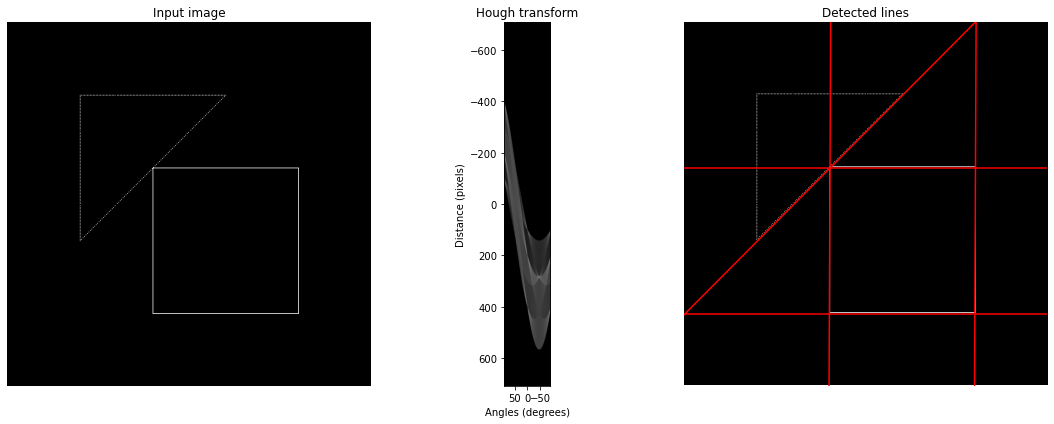

In [3]:
# Constructing test image
M = 500
N = 500
# triangle
line1 = dip_linePoints(100, 100, 100, 300, M, N, 100)
line2 = dip_linePoints(100, 100, 300, 100, M, N, 100)
line3 = dip_linePoints(100, 300, 300, 100, M, N, 100)

# square
line4 = dip_line(200, 200, 200, 400, M, N)
line5 = dip_line(400, 200, 400, 400, M, N)
line6 = dip_line(200, 200, 400, 200, M, N)
line7 = dip_line(200, 400, 400, 400, M, N)

image = (line1 + line2 + line3 + line4 + line5 + line6 + line7 >= 255) * 255

# Classic straight-line Hough transform
# Set a precision of 0.5 degree.
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)
h, theta, d = hough_line(image, theta=tested_angles)

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

# figure 2
ax[1].imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
             cmap=cm.gray, aspect=1/1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

# figure 3
ax[2].imshow(image, cmap=cm.gray)
origin = np.array((0, image.shape[1]))
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    ax[2].plot(origin, (y0, y1), '-r')
ax[2].set_xlim(origin)
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.tight_layout()
plt.show()

Computes the hessian transform of a candidate pixel that can belong to lines in the image. The transformation maps a pixel in the image to a sinusoidal function in the parameters space. The sinusoidal function returns the quantized values for $\theta$ and $\rho$. We choose the quantization for the angle theta based on the accuracy of the orientation of a line in the image. We assume the angle $\theta$ to lie in the interval $0 \leq \theta \lt 180$ so that the relation between $\theta$ and $\rho$ is one-to-one. If the resolution of our image is good enough that we can distinguish lines whose difference in slope is at least one degree we can set the increment to be 1 degree, or $\frac{\pi}{180}$ radiants.
In the same way we can choose the quantization for the distance $\rho$ of a pixel from the origin. Given an image whose shape is (M,N), i.e. M rows and N columns, the distance between any two pixels in the image cannot be bigger than the length of the diagonal of the image in pixels, so $0 \lt \rho \lt \sqrt{M^2 + N^2}$. The increment for the distance is then 1 pixel.
With this quantization we can represent any line in an image, that is represented by the parameters $\theta$ and $\rho$ in the parameters space, with two integer values, $j_{\theta}$ and $i_{\rho}$ that range between 0 and 180 degree and 0 and the length of the diagonal of the image, respectively.

In [28]:
def hessian(u, v, M, N, num_angles = 180): 
    '''
    M = rows (y), N = columns (x)
    u = row (y) index, v = column (x) index
    The function returns two arrays. One array contains
    the list of allowed angles, and the 2nd array contains
    the list of distances from the origin to the line
    '''
    # max_r = np.sqrt(M * M + N * N)
    # Yr = max_r / 2 # parameter space vertical axes origin
    # Xr = max_r / 2 # parameter space horizontal axes origin
    Xr = N / 2
    Yr = M / 2
    theta_rad = np.linspace(0, np.pi - np.pi / num_angles, num_angles)
    #r = (Xr - v) * np.cos(-theta_rad) + (Yr - u) * np.sin(-theta_rad)
    r = -v * np.cos(theta_rad) + u * np.sin(theta_rad)
    theta_deg = (np.rad2deg(theta_rad)).astype(int) # quantized angle
    r = np.rint(r).astype(int) # quantized distance from origin
    return theta_deg, r

In [29]:
def rho(u, v, theta_deg, M, N):
    Xr = N / 2
    Yr = M / 2
    rho_r = Xr * Xr + Yr * Yr
    u_prime = u - Yr
    v_prime = v - Xr
    prod = u * Yr + v * Xr
    theta_rad = np.deg2rad(theta_deg)
    r = (Xr - v) * np.cos(-theta_rad) + (Yr - u) * np.sin(-theta_rad)
    #r_orig = v * np.cos(-theta_rad) + u * np.sin(-theta_rad)
    r_orig = -v * np.cos(theta_rad) + u * np.sin(theta_rad)
    r_orig_int = np.absolute(np.rint(r_orig).astype(int))
    r_int = np.absolute(np.rint(r).astype(int)) 
    return r_int, r_orig_int

In [30]:
rho(100, 100, 135, 500, 500)

(212, 141)

In [31]:
M = 500
N = 500
max_r = np.rint(np.sqrt(M * M + N * N)).astype(int)
Yr = np.rint(0.5 * np.sqrt(M * M + N * N)).astype(int)
max_r, Yr

(707, 354)

In [32]:
theta, r = hessian(200, 100, 500, 500)
r.shape

(180,)

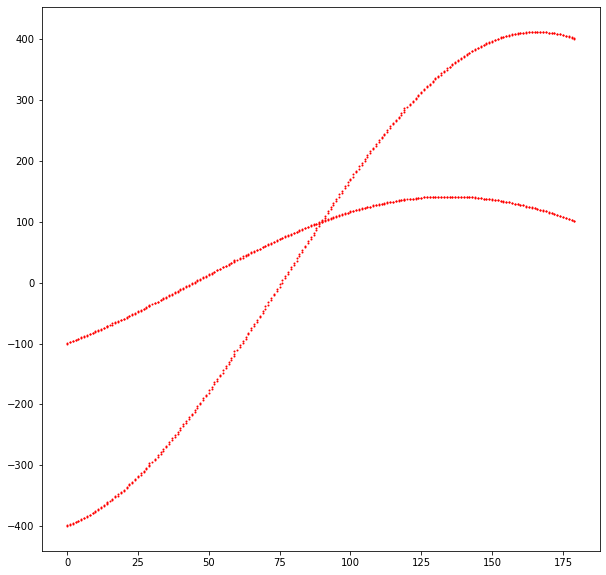

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
#x = [200, 100]
#y = [100, 200] # y = -x + 300 (theta = 135 deg, rho = 212 pixels)
 
x = [100, 100]
y = [100, 400] # y = -x + 500 (theta = 135, rho = 353 pixels)

#x = [200, 400, 100]
#y = [100, 300, 0] # y = x + 100 (theta = 45, rho = 71 pixels)
M = 500
N = 500
for i in range(0, len(x)):
    theta, r = hessian(x[i], y[i], M, N, 360)
    ax.plot(theta, r, color='red', marker='o', linestyle='None', markersize=1)

Now we create a two-dimensional array to be used as accumulator of the Hough transforms in Hessian form of the candidate pixels on which we store the number of times each cell contains a point of any such transform. Since NumPy cannot use negative values for indexes we move the origin of the accumulator map to half the maximum distance between two pixels in the image. In this way we will be able to store the count for the any point in the parameters space. When we want to know the correct distance of one point we will subtract the coordinate of the origin.   

In [36]:
def accumulate(image, num_angles = 180):
    '''
    The function takes an input image and computes the Hughes trasform for
    all pixels whose value is above a threshold (default is 0).
    M is the number of rows of the image, N is the number of columns
    theta and rho are arrays that contain the coordinates of the Hough 
    transform of a pixel in Hessian form. The function returns the accumulator map.
    '''
    M = image.shape[0]
    N = image.shape[1]
    max_r = np.rint(np.sqrt(M * M + N * N)).astype(int)
    Yr = np.rint(0.5 * max_r).astype(int)
    accumulator = np.zeros((max_r, num_angles), dtype=int)
    counter = 0
    for u in range(0, M):
        for v in range(0, N):
            if image[u, v] > 0:
                theta, rho = hessian(u, v, M, N, num_angles)
                for t in range(0, theta.shape[0]):
                    i = np.absolute(rho[t])
                    j = theta[t]
                    accumulator[i, j] += 1
                    
    return accumulator

In [92]:
M = 500
N = 500

line11 = dip_line(100, 100, 100, 300, M, N) # horizontal
line12 = dip_line(100, 100, 300, 100, M, N) # vertical
line13 = dip_line(100, 300, 300, 100, M, N) # diagonal negative

lines_img = line11 + line12 + line13
acc1 = accumulate(lines_img, 360)
acc1.shape

(707, 360)

In [93]:
np.sum(acc1 > 180)

3

In [94]:
i, j = np.unravel_index(np.argmax(acc1, axis=None), acc1.shape) # search the cell indexes of the maximum value
i, j , acc1[i,j]

(283, 135, 284)

We plot the accumulator map, taking into consideration that the origin of the plot is on the upper left corner.

(350.0, 0.0)

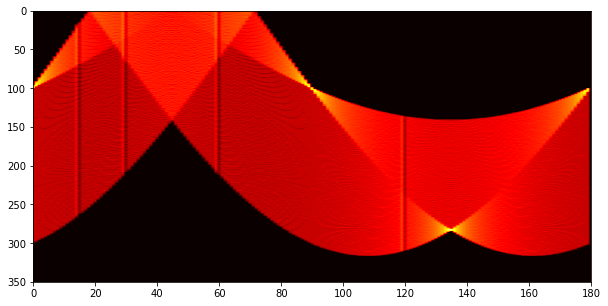

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(10, 20))
ax.imshow(np.log(acc1 + 1), cmap=cm.hot, aspect=1/4)
ax.set_xlim(0, 180)
ax.set_ylim(350, 0)

We want to extract the cells $(\theta, \rho)$ in the accumulator that are more likely to represent a line in the image. We take the cells with a value that is above a certain threshold. Before doing that we want to eliminate from the accumulator map the all the cells whose value is lower than any of its neighboring cell.  

In [41]:
def dip_nonmaxFilter(accumulator, dist = 1):
    '''
    Sets to zero the value of a accumulator cell if any of its neighbor 
    has a equal or higher value, that is, if the cell is nonmaximal.
    The filter looks all the neighbors within a distance, in pixels, set by the
    input variable dist. The default distance is 1.
    The function returns the same accumulator without the nonmaximal points.
    '''
    
    rows = accumulator.shape[0]
    cols = accumulator.shape[1]

    for col in range(0, cols - dist):
        for row in range(0, rows - dist):
            cell_value = accumulator[row, col]
            for i in range(-dist, dist + 1):
                for j in range(-dist, dist + 1):
                    v = accumulator[row + i, col + j]
                    is_center = (i == 0 and j == 0)
                    if v >= cell_value and not is_center:
                            accumulator[row, col] = 0    
    return accumulator

In [42]:
def peaks(accumulator, threshold):
    '''
    The function takes as input an accumumulator map and a
    threshold that represent the minimum value of the accumulator's
    cell to be included in the list of candidate lines.
    '''
    M = accumulator.shape[0]
    N = accumulator.shape[1]
    #Yr = np.rint(0.5 * M).astype(int)
    theta = []
    rho = []
    value = []
    lines = [theta, rho, value]
    for r in range(0, M):
        for c in range(0, N):
            if accumulator[r, c] >= threshold:
                theta.append(c)
                rho.append(r)
                value.append(accumulator[r, c])
    return lines

In [43]:
acc_max1 = dip_nonmaxFilter(acc1, 3)
lines = peaks(acc_max1, 40)
lines

[[1, 0, 90, 179, 91, 178, 92, 177, 135],
 [96, 100, 100, 102, 104, 107, 108, 112, 283],
 [97, 203, 201, 160, 97, 69, 54, 44, 284]]

We use the functions defined above to find lines within a binary image

In [44]:
def extract_lines(accumulator, threshold, dist = 1): # Constructing test image
    acc_max = dip_nonmaxFilter(accumulator, dist)
    lines = peaks(acc_max, threshold)
    return lines

In [45]:
lines = extract_lines(acc_max1, 40, 3)
len(lines[0])

9

We compute the slope and the intercept of each line from the angle $\theta$ and the distance from the origin $\rho$

In [46]:
def hesse2image(theta, rho):
    intercept = rho
    slope = np.inf
    if theta > 0 and theta < 180:
        theta_rad = np.deg2rad(theta)
        slope = np.cos(theta_rad) / np.sin(theta_rad)
        intercept = rho / np.sin(theta_rad)
    return slope, intercept

In [47]:
hesse2image(lines[0][0], lines[1][0])

(57.28996163075943, 5500.674095860818)

Finally we plot the lines

53
7


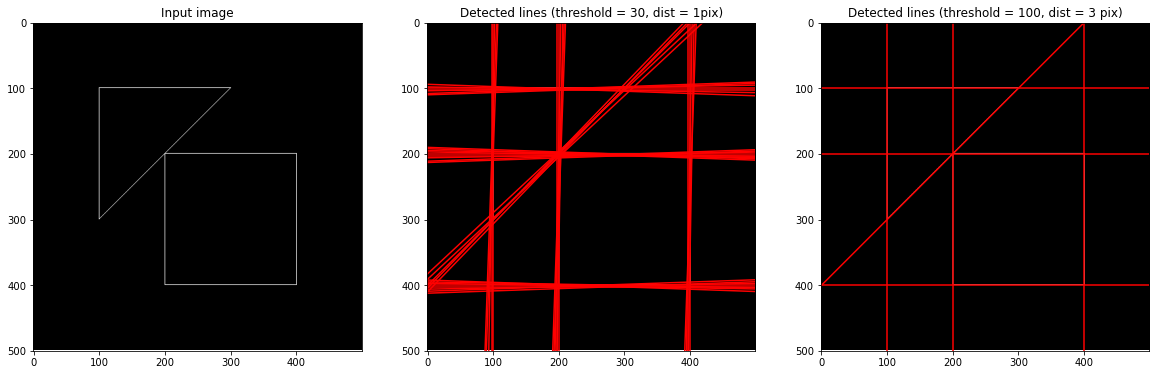

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 12))

M = 500
N = 500
Xr = M / 2
Yr = N / 2
max_r = np.rint(0.25 * np.sqrt(M * M + N * N)).astype(int)
# triangle
line22 = dip_line(100, 100, 300, 100, M, N) # vertial
line23 = dip_line(100, 300, 300, 100, M, N) # diagonal
line21 = dip_line(100, 100, 100, 300, M, N) # horizontal

# square
line24 = dip_line(200, 200, 200, 400, M, N) # horizontal up
line25 = dip_line(400, 200, 400, 400, M, N) # horizontal down
line26 = dip_line(200, 200, 400, 200, M, N) # vertical left
line27 = dip_line(200, 400, 400, 400, M, N) # vertical right

lines_img1 = ((line21 + line22 + line23 + line24 + line25 + line26 + line27) >= 255) * 255  # input image
#lines_img1 = ((line24 + line25 + line26 + line27) >= 255) * 255  # input image
acc2 = accumulate(lines_img1, 360) # accumulator map of the input image

# plot the input image
axes[0].imshow(lines_img1, cmap=cm.gray)
axes[0].set_title('Input image')
axes[0].set_ylim(M, 0)

# plot the accumulator map
#axes[1].imshow(acc, cmap=cm.gray)
    
# detected lines
axes[1].imshow(lines_img1, cmap=cm.gray)
x = np.linspace(0, lines_img1.shape[1] - 1, lines_img1.shape[1])
y = np.zeros(M, dtype=int)
lines = extract_lines(acc2, 50, 1)
print(len(lines[0]))
for i in range(0, len(lines[0])):
    theta = lines[0][i]
    rho = lines[1][i]
    slope, intercept = hesse2image(theta, rho)
    if slope != np.inf:
        y = slope * x + intercept
        axes[1].plot(x, y, color='red')
    elif intercept < M:
        axes[1].axvline(x=intercept, color='red')
    axes[1].set_ylim(M, 0)
    axes[1].set_title('Detected lines (threshold = 30, dist = 1pix)')
    
# detected lines 2
axes[2].imshow(lines_img1, cmap=cm.gray)
x = np.linspace(0, lines_img1.shape[1] - 1, lines_img1.shape[1])
y = np.zeros(M, dtype=int)
lines = extract_lines(acc2, 200, 5)
print(len(lines[0]))
for i in range(0, len(lines[0])):
    theta = lines[0][i]
    rho = lines[1][i]
    slope, intercept = hesse2image(theta, rho)
    if slope != np.inf:
        y = slope * x + intercept
        axes[2].plot(x, y, color='red')
    elif intercept < M:
        axes[2].axvline(x=intercept, color='red')
    axes[2].set_ylim(M, 0)
    axes[2].set_title('Detected lines (threshold = 100, dist = 3 pix)') 

#plt.savefig('hough_transform.png')

Now we apply the Hough transformation to a picture with a natural scene.

((800, 600), 255)

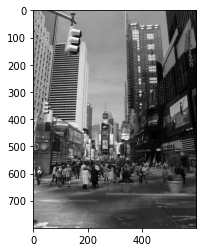

In [48]:
#test_img = io.imread('images/wdg3.png')[:,:,0]
#test_img = io.imread('images/mesons.png')[:,:,0]
test_img = io.imread('images/times_square.jpg')[:,:,0]
#test_img = io.imread('images/australia_road.jpg')[:,:,0]
#test_img = skimage.data.brick()
plt.imshow(test_img, cmap='gray')
test_img.shape, test_img.max()

In [49]:
derived_img = dip_localGradient(test_img)

In [50]:
np.sum(test_img > 200)

25200

In [53]:
#binary_img = np.transpose(dip_threshold(test_img, 100, 255, 0))
binary_img = dip_threshold(test_img, 100, 255, 0)
binary_img.shape

(800, 600)

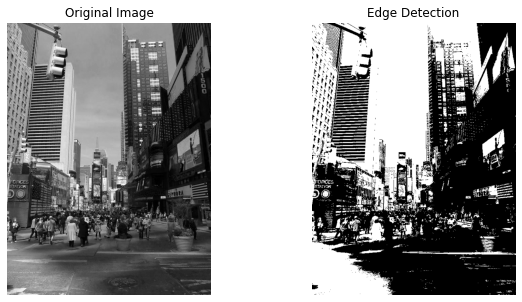

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].set_title('Original Image')
axes[0].set_axis_off()
axes[0].imshow(test_img, cmap='gray')
axes[1].set_title('Edge Detection')
axes[1].set_axis_off()
axes[1].imshow(binary_img, cmap='gray')
#plt.savefig('camera_edge_detection.png')

In [55]:
acc = accumulate(binary_img)

In [56]:
lines = extract_lines(acc, 400, 1)
len(lines[0])

5290

We plot the binary image extracted by the edge detector and then the same image with the found lines

132


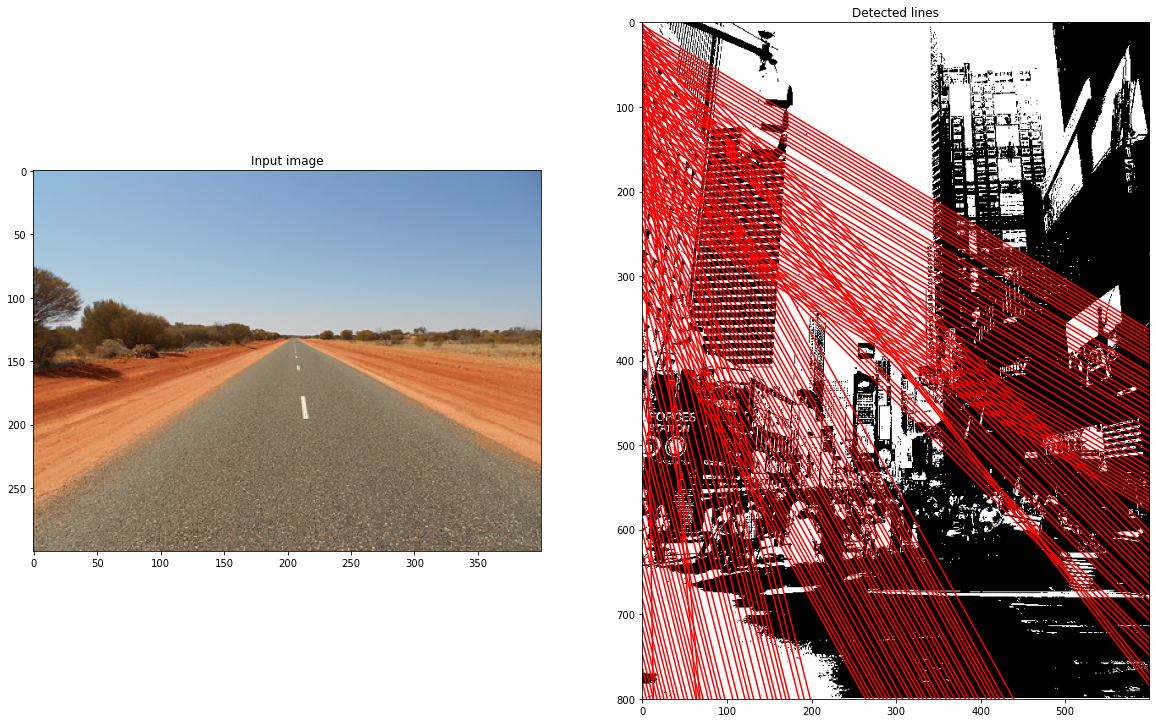

In [59]:
australia_road_img = io.imread('images/australia_road.jpg')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))
M = binary_img.shape[0]
N = binary_img.shape[1]
axes[0].imshow(australia_road_img)
axes[0].set_title('Input image')
#axes[0].set_ylim(M, 0)

axes[1].imshow(binary_img, cmap=cm.gray)
x = np.linspace(0, binary_img.shape[1] - 1, binary_img.shape[1])
y = np.zeros(M, dtype=int)
#acc = accumulate(binary_img)
lines = extract_lines(acc, 1000, 3)
print(len(lines[0]))
for i in range(0, len(lines[0])):
    theta = lines[0][i]
    rho = lines[1][i]
    slope, intercept = hesse2image(theta, rho)
    if slope != np.inf:
        y = slope * x + intercept
        axes[1].plot(x, y, color='red')
    else:
        axes[1].axvline(x=intercept, color='red')
    axes[1].set_ylim(M, 0)
    axes[1].set_title('Detected lines') 
plt.savefig('road_detection_hough_transform.png')

# figure 3

#tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)
#h, theta, d = hough_line(binary_img, theta=tested_angles)
#axes[2].imshow(binary_img, cmap=cm.gray)
#origin = np.array((0, binary_img.shape[1]))
#for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
#    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
#    axes[2].plot(origin, (y0, y1), '-r')
#axes[2].set_xlim(origin)
#axes[2].set_ylim((binary_img.shape[0], 0))
#axes[2].set_title('Detected lines')


## References
[Duda, Hart - Use of the Hough Transformation to Detect Lines and Curves in Pictures](https://www.cse.unr.edu/~bebis/CS474/Handouts/HoughTransformPaper.pdf)